In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

print("Model Mean \n", model_mean)
print("Model Variance \n", model_variance)
print("Model Standard Deviation \n", model_stdev)
print("Model y \n", model_y)
print("Y Value Expected \n", y_exp)

Model Mean 
 tensor([ 2.9907, -6.2356, -5.0282, -7.5617, -1.9588, -0.5184],
       dtype=torch.float64)
Model Variance 
 tensor([7.0452, 6.6659, 6.6159, 7.9151, 5.9328, 5.7720], dtype=torch.float64)
Model Standard Deviation 
 tensor([2.6543, 2.5818, 2.5721, 2.8134, 2.4357, 2.4025], dtype=torch.float64)
Model y 
 tensor([ 2.9907, -6.2356, -5.0282, -7.5617, -1.9588, -0.5184],
       dtype=torch.float64)
Y Value Expected 
 [ 9.70311757e+00 -6.46570440e+00 -3.27672656e+00 -1.18636079e+01
  1.81407211e-03  1.08898812e+00]


In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("Best Error is: ",best_error)
print("EI:",ei)

Upper bound is [ 2.61561642  0.          0.77040883 -1.44729189  0.89943737  0.76483189]
Lower bound is [ 2.44220712 -0.17827514  0.59146173 -1.61089512  0.71046914  0.57324823]
pdf upper is [0.01304092 0.39894228 0.29650138 0.13997864 0.26621998 0.29777341]
cdf upper is [0.99554667 0.5        0.77947129 0.07390759 0.81579013 0.77781417]
pdf lower is [0.02021913 0.39265279 0.33492387 0.10899753 0.30995699 0.33849522]
cdf lower is [0.99270112 0.42925345 0.72289446 0.05360129 0.76129337 0.71676168]
[0.48390431 0.25       0.35352058 0.07653088 0.36880561 0.35284171]
[0.44979427 0.25       0.1250933  0.27912083 0.12935741 0.12509511]
Best Error is:  0.052964002882897133
EI: [-0.52630133  0.29196781 -0.46470348 -1.44021897 -0.64466288 -0.41384537]


Lower Improvement Integrand is 
 [ 0.00000000e+00  0.00000000e+00 -3.48600181e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Upper Improvement Integrand is 
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.77090828e-17 0.00000000e+00]


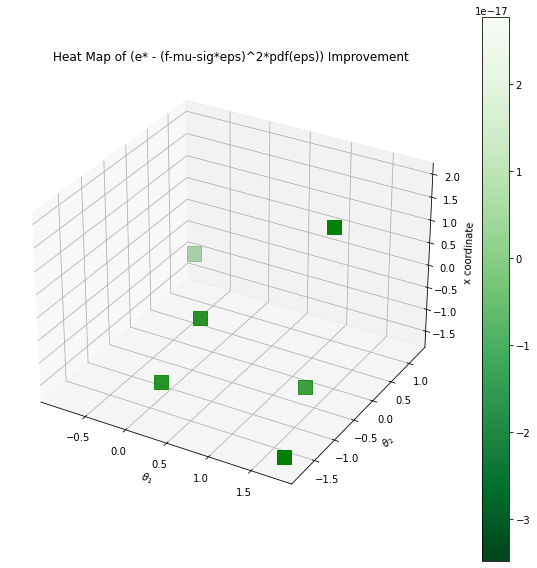

None


In [8]:
Integrand_values = improvement(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )
print(improvement_plot(test_p,Integrand_values))

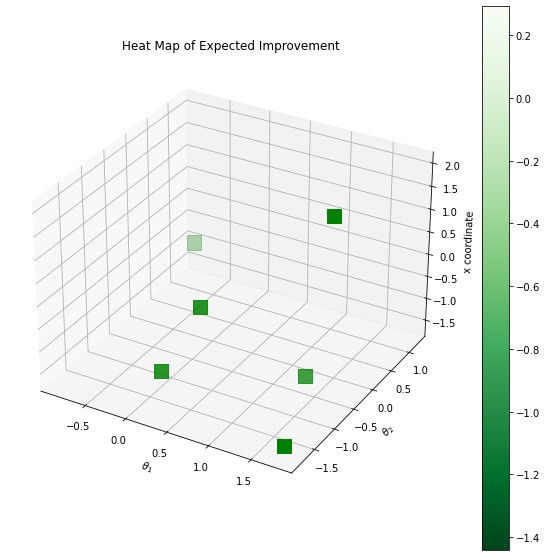

None


In [9]:
print(ei_plotter_adv(test_p, ei))

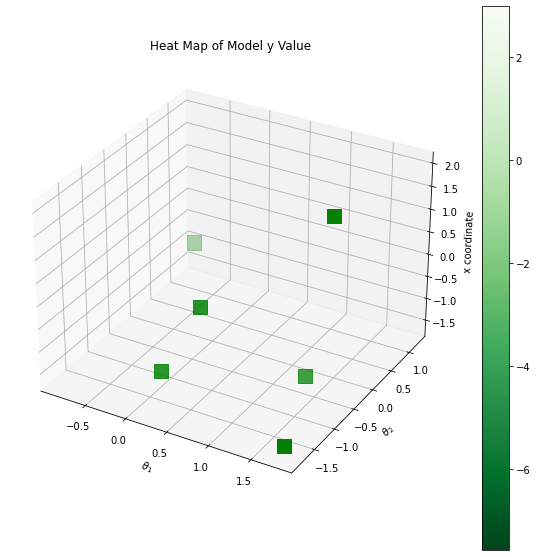

None


In [10]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))